# View sequence of clustering images

In [1]:
# Use the novnc Desktop in the other window
import os
os.environ['DISPLAY'] = ':1.0'
#os.environ['NAPARI_ASYNC']='1'
#os.environ['NAPARI_ASYNC']='1.0' #gives explicit error
#del os.environ['NAPARI_ASYNC']
#os.environ['NAPARI_OCTREE']='1'
#del os.environ['NAPARI_OCTREE']
# instantiate Qt GUI
%gui qt5
#os.environ

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import cv2
import skimage
import tifffile as tf
import os
import pandas as pd
import napari
print(napari.__version__)
from dask_image.imread import imread
import dask.array as da
import io

import platform
if platform.system() == 'Windows':
    fileroot = 'X:/'
    print('Loading Windows')
if platform.system() == 'Linux':
    fileroot = '/home/jovyan/'
    print('Loading Linux')
if False:
    fileroot = '/home/ubuntu/Documents/'

colors_new=['#0072b2','#d55e00','#009e73', '#cc79a7','#f0e442','#56b4e9']

import sys
sys.path.append(fileroot+'VU_TEX/Ben_utilities/')
import useful_functions as uf
import numba_funcs as nf
sys.path.append(fileroot+'VU_TEX/git/large-condensed-tree/')

0.4.17
Loading Linux


In [4]:
from numba import njit
from copy import deepcopy
import matplotlib
from matplotlib.colors import to_rgb, to_rgba
from functools import partial
from importlib import reload
reload(nf)
from tqdm import tqdm

In [5]:
from PIL import Image
from skimage import color
Image.MAX_IMAGE_PIXELS = 1000000000

## Loading colors

In [6]:
#colors = uf.return_color_scale('Omer_chosen_colors_dark_first')
colors_with_inital_grey = deepcopy(colors_new)
colors_with_inital_grey.insert(0, 'gray')
rgb_colors_with_inital_grey = np.asarray(255*np.array([to_rgb(color) for color in colors_with_inital_grey]), int)
print(rgb_colors_with_inital_grey)
dict_colors = {i:color for i, color in enumerate(colors_with_inital_grey)}
print(dict_colors )

[[128 128 128]
 [  0 114 178]
 [213  94   0]
 [  0 158 115]
 [204 121 167]
 [240 228  66]
 [ 86 180 233]]
{0: 'gray', 1: '#0072b2', 2: '#d55e00', 3: '#009e73', 4: '#cc79a7', 5: '#f0e442', 6: '#56b4e9'}


In [7]:
rgba_colors_with_inital_grey = np.asarray(255*np.array([to_rgba(color) for color in colors_with_inital_grey]), int)
rgba_colors_with_inital_transparent = rgba_colors_with_inital_grey
rgba_colors_with_inital_transparent[0] = 0
rgba_colors_with_inital_transparent
dict_colors_initial_transp = {i:color for i, color in enumerate(rgba_colors_with_inital_transparent)}
display(dict_colors_initial_transp)
dict_colors_initial_transp_0to1 = {i:color/255 for i, color in enumerate(rgba_colors_with_inital_transparent)}
dict_colors_initial_transp_0to1

{0: array([0, 0, 0, 0]),
 1: array([  0, 114, 178, 255]),
 2: array([213,  94,   0, 255]),
 3: array([  0, 158, 115, 255]),
 4: array([204, 121, 167, 255]),
 5: array([240, 228,  66, 255]),
 6: array([ 86, 180, 233, 255])}

{0: array([0., 0., 0., 0.]),
 1: array([0.        , 0.44705882, 0.69803922, 1.        ]),
 2: array([0.83529412, 0.36862745, 0.        , 1.        ]),
 3: array([0.        , 0.61960784, 0.45098039, 1.        ]),
 4: array([0.8       , 0.4745098 , 0.65490196, 1.        ]),
 5: array([0.94117647, 0.89411765, 0.25882353, 1.        ]),
 6: array([0.3372549 , 0.70588235, 0.91372549, 1.        ])}

In [8]:
dict_gray_out_colors = {0:np.array([0,0,0,0], float), 1:np.array([0,0,0,1], float)}
dict_gray_out_colors

{0: array([0., 0., 0., 0.]), 1: array([0., 0., 0., 1.])}

In [9]:
rgb_colors_with_inital_grey = np.asarray(255*np.array([to_rgb(color) for color in colors_with_inital_grey]), int)
print(rgb_colors_with_inital_grey)
dict_colors = {i:color for i, color in enumerate(colors_with_inital_grey)}
print(dict_colors)
rgb_colors_with_inital_grey_0to1 = np.asarray(np.array([to_rgb(color) for color in colors_with_inital_grey]), float)
rgb_colors_with_inital_grey_0to1

[[128 128 128]
 [  0 114 178]
 [213  94   0]
 [  0 158 115]
 [204 121 167]
 [240 228  66]
 [ 86 180 233]]
{0: 'gray', 1: '#0072b2', 2: '#d55e00', 3: '#009e73', 4: '#cc79a7', 5: '#f0e442', 6: '#56b4e9'}


array([[0.50196078, 0.50196078, 0.50196078],
       [0.        , 0.44705882, 0.69803922],
       [0.83529412, 0.36862745, 0.        ],
       [0.        , 0.61960784, 0.45098039],
       [0.8       , 0.4745098 , 0.65490196],
       [0.94117647, 0.89411765, 0.25882353],
       [0.3372549 , 0.70588235, 0.91372549]])

## Loading data

In [10]:
#directory_images_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
directory_images_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
filename_images_metadata = '2022-09-01_IVY_GAP_metadata.csv'
df_images_metadata = pd.read_csv(directory_images_metadata + filename_images_metadata, index_col=0)
df_images_metadata = df_images_metadata.loc[df_images_metadata['original_index'].isin([50, 594, 406, 418, 
267, 290, 474, 231, 498, 217, 
309, 544])]
df_images_metadata

,original_index,annotated,output_filename,output_filename_annotations,bits_per_component,data_set_id,expression_x,height,subimage_id,image_height,...,extent_of_resection,mgmt_methylation,pten_deletion,radiation_therapy,tumor_status,initial_kps,time_to_progression_or_recurrence,mgmt_ihc,survival_days,molecular_subtype
50,50,False,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...,8.0,273294277,NaN,18080,273294441,44736,...,Complete,No,Yes,Yes,primary,90,102.0,80.0,540.0,"Mesenchymal, Neural"
217,217,True,donor_id_12165_specimen_id_706867_subimage_id_...,donor_id_12165_specimen_id_706867_subimage_id_...,8.0,300631275,False,18048,300631309,29632,...,Sub-total,No,No,No,primary,70,7.0,20.0,80.0,Classical
231,231,False,donor_id_12111_specimen_id_301589924_subimage_...,donor_id_12111_specimen_id_301589924_subimage_...,8.0,302049403,False,18048,302049407,29376,...,Complete,Yes,No,Yes,primary,100,NaN,0.0,NaN,Proneural
267,267,False,donor_id_12108_specimen_id_298804531_subimage_...,donor_id_12108_specimen_id_298804531_subimage_...,8.0,309715108,False,18048,309715132,46176,...,Complete,No,No,Yes,primary,70,29.0,20.0,442.0,"Classical, Mesenchymal"
290,290,False,donor_id_12111_specimen_id_310607296_subimage_...,donor_id_12111_specimen_id_310607296_subimage_...,NaN,311174529,NaN,18048,311174531,44160,...,Complete,Yes,No,Yes,primary,100,NaN,0.0,NaN,Proneural
309,309,False,donor_id_292023109_specimen_id_293252159_subim...,donor_id_292023109_specimen_id_293252159_subim...,8.0,294219122,NaN,18080,294219224,44512,...,Complete,Yes,NaN,Yes,primary,100,NaN,NaN,NaN,Classical
406,406,True,donor_id_12112_specimen_id_299863542_subimage_...,donor_id_12112_specimen_id_299863542_subimage_...,8.0,300630250,False,18048,300630264,28480,...,Complete,Yes,No,Yes,primary,100,159.0,50.0,1076.0,"Classical, Mesenchymal"
418,418,False,donor_id_12165_specimen_id_706710_subimage_id_...,donor_id_12165_specimen_id_706710_subimage_id_...,8.0,100125322,NaN,17152,101713024,38944,...,Sub-total,No,No,No,primary,70,7.0,20.0,80.0,Classical
474,474,False,donor_id_12165_specimen_id_287815403_subimage_...,donor_id_12165_specimen_id_287815403_subimage_...,8.0,292343853,NaN,18080,292344018,43904,...,Sub-total,No,No,No,primary,70,7.0,20.0,80.0,Classical
498,498,False,donor_id_15343_specimen_id_281857486_subimage_...,donor_id_15343_specimen_id_281857486_subimage_...,8.0,286687999,NaN,18080,286688001,45760,...,Sub-total,Yes,No,Yes,primary,70,236.0,0.0,311.0,Proneural


In [11]:
patchsize = 200
this_original_index = 267 #594, 474
#[50, 594, 406, 418, 267, 290, 474, 231, 498, 217, 309, 544] #474
filename_img = df_images_metadata.loc[this_original_index]['output_filename']; print(filename_img)
filename_gt_original_res = df_images_metadata.loc[this_original_index]['output_filename_annotations']; 
print(filename_gt_original_res)

donor_id_12108_specimen_id_298804531_subimage_id_309715132.jpg
donor_id_12108_specimen_id_298804531_subimage_id_309715132_annotation.jpg


In [12]:
directory_img = fileroot + '0ExternalData/2022-09-01_IVY_GAP/2022-08-31_originals/'
original = skimage.io.imread(directory_img + filename_img)
final_target_size = 1

In [13]:
directory_colors_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
filename_colors_metadata = '2022-09-02_colors_for_IVY_GAP.csv'
df_colors = pd.read_csv(directory_colors_metadata + filename_colors_metadata, index_col=0)
df_colors_out = df_colors.set_index('color_indices').loc[:, ['white_first']].squeeze().to_dict()
df_colors_out

{0: '#Ffffff',
 1: '#006400',
 2: '#ff1493',
 3: '#a6730a',
 4: '#ff8c00',
 5: '#00bfff',
 6: '#0000ff',
 7: '#ffd700',
 8: '#800080',
 9: '#000054'}

In [14]:
df_colors_out_no_zero = {key:value for key,value in df_colors_out.items() if key != 0}
df_colors_out_no_zero 

{1: '#006400',
 2: '#ff1493',
 3: '#a6730a',
 4: '#ff8c00',
 5: '#00bfff',
 6: '#0000ff',
 7: '#ffd700',
 8: '#800080',
 9: '#000054'}

[0 1 2 3]


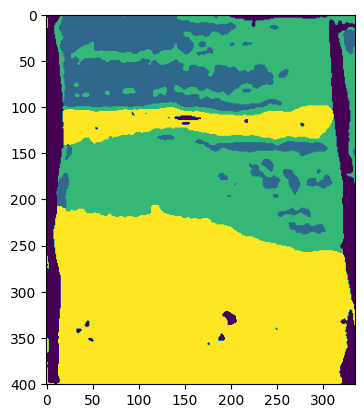

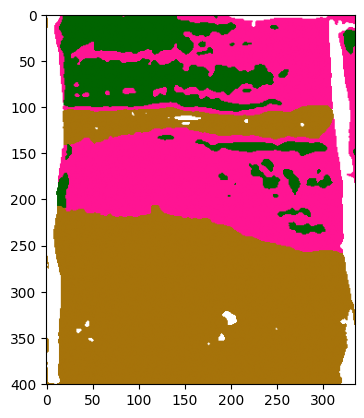

In [15]:
#optional
directory_gt_original_res = fileroot + '0ExternalData/2022-09-01_IVY_GAP/2022-09-02_integer_annotations/'
gt_45 = np.load(directory_gt_original_res + filename_gt_original_res.replace('.jpg', '.npy'))
print(np.unique(gt_45))
plt.imshow(gt_45)
plt.show()
rgb_gt_45 = uf.label2rgb_with_dict(gt_45, df_colors_out)
plt.imshow(rgb_gt_45)
plt.show()

In [16]:
directory_output_masks = 'HDBScan_Output_masks/'
filenames = os.listdir(directory_output_masks)
filenames

['C_4_Imageindex_267_rgb.npy',
 'C_3_Imageindex_418_ints.npy',
 'C_11_Imageindex_544_rgb.npy',
 'C_5_Imageindex_290_rgb.npy',
 'C_9_Imageindex_217_ints.npy',
 'C_0_Imageindex_50_rgb.npy',
 'C_1_Imageindex_594_ints.npy',
 'C_0_Imageindex_406_ints.npy',
 'C_1_Imageindex_594_rgb.npy',
 'C_6_Imageindex_474_rgb.npy',
 'C_0_Imageindex_50_ints.npy',
 'C_0_Imageindex_231_rgb.npy',
 'C_4_Imageindex_267_ints.npy',
 'C_8_Imageindex_498_rgb.npy',
 'C_2_Imageindex_406_ints.npy',
 'C_0_Imageindex_406_rgb.npy',
 'C_10_Imageindex_309_ints.npy',
 'C_0_Imageindex_231_ints.npy',
 'C_7_Imageindex_231_rgb.npy',
 'C_11_Imageindex_544_ints.npy',
 'C_5_Imageindex_290_ints.npy',
 'C_6_Imageindex_474_ints.npy',
 'C_9_Imageindex_217_rgb.npy',
 'C_7_Imageindex_231_ints.npy',
 'C_2_Imageindex_406_rgb.npy',
 'C_3_Imageindex_418_rgb.npy',
 'C_8_Imageindex_498_ints.npy',
 'C_10_Imageindex_309_rgb.npy']

['C_4_Imageindex_267_rgb.npy', 'C_4_Imageindex_267_ints.npy']
C_4_Imageindex_267_ints.npy
C_4_Imageindex_267_rgb.npy


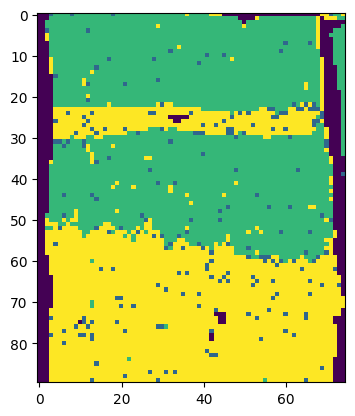

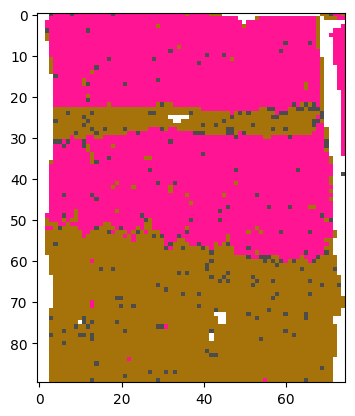

In [17]:
from skimage import img_as_ubyte
this_index_filenames = [each for each in filenames if 'Imageindex_'+str(this_original_index) in each]
print(this_index_filenames)
myfilename_ints = [each for each in this_index_filenames if 'ints' in each][0]
print(myfilename_ints)
myfilename_rgb = [each for each in this_index_filenames if 'rgb' in each][0]
print(myfilename_rgb)
intlabels = np.load(directory_output_masks + myfilename_ints)
intlabels -= np.min(intlabels)
plt.imshow(intlabels)
plt.show()
rgblabels = img_as_ubyte(np.load(directory_output_masks + myfilename_rgb))
plt.imshow(rgblabels)
plt.show()

In [18]:
np.unique(intlabels)

array([0, 1, 2, 3], dtype=int16)

In [19]:
int_to_rgb_dict = uf.intlabels_and_rgblabels_to_dict(intlabels, rgblabels, list_to_ignore = [], divide_by_255=True)
int_to_rgb_dict

{0: array([1., 1., 1.]),
 1: array([0.29803922, 0.29803922, 0.29803922]),
 2: array([1.        , 0.07843137, 0.57647059]),
 3: array([0.65098039, 0.45098039, 0.03921569])}

In [20]:
int_to_rgb_dict_no_zero = uf.intlabels_and_rgblabels_to_dict(intlabels, rgblabels, list_to_ignore = [0], divide_by_255=True)
int_to_rgb_dict_no_zero

{1: array([0.29803922, 0.29803922, 0.29803922]),
 2: array([1.        , 0.07843137, 0.57647059]),
 3: array([0.65098039, 0.45098039, 0.03921569])}

In [21]:
intlabels.dtype, np.max(intlabels), np.min(intlabels)

(dtype('int16'), 3, 0)

# Napari load

In [22]:
viewer = napari.Viewer()

In [23]:
#original_pyr = uf.get_pyramid_hybrid_loading(original, 2000, 200000)
#original_pyr = [original[::i, ::i] for i in [1, 2, 4, 8, 16, 32]]
#original_pyr = [original[::i, ::i] for i in [1, 2]]
#original_pyr = [np.copy(original[::i, ::i]) for i in [1, 2]]
#original_pyr = [np.copy(original[::i, ::i]) for i in [1, 2, 4, 8, 16, 32]]
original_pyr = uf.get_pyramid_hybrid_loading(original, 1000, 200000)
[each.shape for each in original_pyr]

[(18048, 15104, 3),
 (9024, 7552, 3),
 (4512, 3776, 3),
 (2256, 1888, 3),
 (1128, 944, 3),
 (564, 472, 3)]

In [24]:
original_pyr

[array([[[248, 246, 247],
         [248, 246, 247],
         [248, 246, 247],
         ...,
         [238, 196, 210],
         [245, 204, 218],
         [251, 210, 224]],
 
        [[248, 246, 247],
         [248, 246, 247],
         [248, 246, 247],
         ...,
         [238, 196, 210],
         [245, 204, 218],
         [251, 210, 224]],
 
        [[248, 246, 247],
         [248, 246, 247],
         [248, 246, 247],
         ...,
         [237, 195, 209],
         [244, 203, 217],
         [250, 209, 223]],
 
        ...,
 
        [[249, 249, 247],
         [249, 249, 247],
         [249, 249, 247],
         ...,
         [247, 249, 248],
         [247, 249, 248],
         [247, 249, 248]],
 
        [[248, 248, 246],
         [248, 248, 246],
         [248, 248, 246],
         ...,
         [247, 249, 248],
         [247, 249, 248],
         [247, 249, 248]],
 
        [[247, 247, 245],
         [247, 247, 245],
         [247, 247, 245],
         ...,
         [247, 249, 248],
  

In [25]:
viewer.add_image(original_pyr, name='Original image')
#viewer.add_image(original, name='Original image')

<Image layer 'Original image' at 0x14ce7b1c0a90>

In [26]:
#optional
if 'gt' in globals():
    gt_pyr = uf.get_pyramid_hybrid_loading(gt, 1000, 200000)
    viewer.add_labels(gt_pyr, name='Groundtruth', visible=False, color=int_to_rgb_dict,)

In [34]:
#optional
if 'gt_45' in globals() and True:
    gt_45_upsize = uf.upsize(gt_45, 45)
    gt_45_pyr = uf.get_pyramid_hybrid_loading(gt_45_upsize, 1000, 200000)
    viewer.add_labels(gt_45_pyr, name='Groundtruth_clusters', visible=False, color=df_colors_out)
    
    output_edges_gt_45 = nf.get_edges_of_cluster_shapes_with_partial_upscale(gt_45, rgb_gt_45, k=6,
                                                                       partial_upscale = 5,
                                                                       final_upscale = 45,
                                                                      image_edges_drawn = True,
                                                                      output_type='int')

    pyr_cluster_edges_gt_45 = uf.get_pyramid_hybrid_loading(output_edges_gt_45, 1000, 200000)

    viewer.add_labels(pyr_cluster_edges_gt_45, color = df_colors_out_no_zero, name='Groundtruth_edges', opacity=1)

In [28]:
@njit
def rgb2labelint_iterator(img, array_of_colors):
    output = np.zeros((img.shape[0], img.shape[1]), dtype=img.dtype)
    len_array_colors = len(array_of_colors)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(len_array_colors):
                if np.all(np.equal(array_of_colors[k], img[i,j])):
                    output[i,j] = k
#            output[i,j] = np.argmax(np.all(np.equal(img[i,j], array_of_colors), axis=1))
    return output
    
    
def rgb2labelint(img, array_of_colors = None):
    if array_of_colors is None:
        array_of_colors = np.unique(myimg.reshape(-1, myimg.shape[2]), axis=0)
    output = rgb2labelint_iterator(img, array_of_colors)
    return output

#intlabels = rgb2labelint(myimg, rgb_colors_with_inital_grey)
#plt.figure(figsize=(25,5))
#plt.imshow(intlabels)

In [35]:
partial_upscale = 10
#this the partial upscale needed for creating the edges labels layer
#the higher this number, the smoother the edges are displayed but the slower it takes
final_upscale = int(patchsize / (final_target_size))
    
#This next part grays out the areas that are not part of clusters
if True:
    not_clusters_yet = nf.upsize(intlabels <= 1, patchsize)
    pyr_not_clusters = uf.get_pyramid_hybrid_loading(not_clusters_yet, 1000, 2000000)
    viewer.add_labels(pyr_not_clusters, color=dict_gray_out_colors, 
                      name='Part of any cluster', visible=False)

#This next part creates a labels layer that shows the edges of the clusters
if True:
#    rgbalabels = nf.convert_rgb_to_rgba(rgblabels, transparent=np.array([255, 255, 255]), transparency_val = 255)
    output_edges = nf.get_edges_of_cluster_shapes_with_partial_upscale(intlabels, rgblabels, k=4,
                                                                       partial_upscale = partial_upscale,
                                                                       final_upscale = final_upscale,
                                                                      image_edges_drawn = True,
                                                                      output_type='int')
#    intlabels_partial_upsize = nf.upsize(intlabels, partial_upscale)
#    rgblabels_partial_upsize = nf.upsize2(rgblabels, partial_upscale)

#    output_edges = nf.get_edges_of_cluster_shapes(intlabels_partial_upsize, rgblabels_partial_upsize, k=4)
#    output_edges_labels_for_int_layer = rgb2labelint(output_edges, rgb_colors_with_inital_grey)    
#    output_edges_labels_for_int_layer_fullsize = nf.upsize(output_edges_labels_for_int_layer, further_upscale)

#    pyr_cluster_edges = uf.get_pyramid_hybrid_loading(output_edges_labels_for_int_layer_fullsize, 2000, 2000000)
#    pyr_cluster_edges = [output_edges[::i, ::i] for i in [1, 2, 4, 8, 16, 32]]
    pyr_cluster_edges = uf.get_pyramid_hybrid_loading(output_edges, 1000, 200000)
#    viewer.add_labels(pyr_cluster_edges, color=dict_colors_initial_transp_0to1, 
#                      name='Cluster edges', visible=False, opacity=1)
    viewer.add_labels(pyr_cluster_edges, color = int_to_rgb_dict_no_zero, name='Our edges', opacity=1)

#This next part shows the clusters as shaded patches
if True:
    intlabels_upsized = nf.upsize(intlabels, final_upscale)
    intlabels_pyr = uf.get_pyramid_hybrid_loading(intlabels_upsized, 1000, 200000)
    viewer.add_labels(intlabels_pyr, color=int_to_rgb_dict, 
                      name='Our clusters', opacity=0.2, visible=False)
#    cluster_patches_int = rgb2labelint(rgblabels_partial_upsize, rgb_colors_with_inital_grey)
#    cluster_patches_int_fullsize = nf.upsize(cluster_patches_int, further_upscale)
#    img_clusters = uf.get_pyramid_hybrid_loading(cluster_patches_int_fullsize, 2000, 2000000)
#    viewer.add_labels(img_clusters, color=dict_colors_initial_transp_0to1, 
#                      name='Shaded clusters', opacity=0.2)